# DAT200 CA5 2022

Kaggle username: aarondeleyos

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from scipy import stats
from sklearn.utils.fixes import loguniform
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### Reading data

In [2]:
training_data = pd.read_csv(r'data\train.csv')
training_data = training_data.drop('Unnamed: 0', axis=1)

### Data exploration and visualisation

In [3]:
# Check dataset for any missing values
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 618 entries, 0 to 617
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Capsaicin level              618 non-null    float64
 1   Pungent odor                 618 non-null    float64
 2   Vitamin C                    618 non-null    float64
 3   Water                        618 non-null    float64
 4   Light transmittance          618 non-null    float64
 5   Temp storage                 618 non-null    float64
 6   Time storage                 618 non-null    float64
 7   Dihydrocapsaicin level       618 non-null    float64
 8   Fibre density                618 non-null    float64
 9   Protein density              618 non-null    float64
 10  Saturated fatty acids        618 non-null    float64
 11  Monounsaturated fatty acids  618 non-null    float64
 12  Polyunsaturated fatty acids  618 non-null    float64
 13  Scoville score      

In [4]:
training_data.describe()

Capsaicin level  Pungent odor   Vitamin C       Water  \
count       618.000000    618.000000  618.000000  618.000000   
mean        146.695793      2.699191   50.893689   79.365534   
std          73.834312      1.980640   63.439770    4.041304   
min          21.300000      1.000000    0.000000   67.400000   
25%          83.450000      1.000000    0.000000   76.395000   
50%         141.800000      1.500000    0.000000   79.960000   
75%         200.600000      4.375000  115.900000   81.190000   
max         322.600000      9.000000  195.000000   91.980000   

       Light transmittance  Temp storage  Time storage  \
count           618.000000    618.000000    618.000000   
mean             29.245146      6.461974     32.309061   
std               6.812141      1.097615     14.251957   
min              22.400000      4.000000      1.000000   
25%              22.400000      5.900000     24.000000   
50%              29.400000      6.400000     34.000000   
75%              34.000000      7.375000     41.000000   
max              59.800000      8.900000     72.000000   

       Dihydrocapsaicin level  Fibre density  Protein density  \
count              618.000000     618.000000       618.000000   
mean                28.453722      15.486359         0.974547   
std                 26.017481      10.894662         0.081469   
min                  9.400000       0.100000         0.910000   
25%                 14.800000       7.315000         0.920000   
50%                 20.700000      13.420000         0.950000   
75%                 32.400000      21.135000         0.990000   
max                161.700000      65.200000         1.490000   

       Saturated fatty acids  Monounsaturated fatty acids  \
count             618.000000                   618.000000   
mean               16.798883                     1.527443   
std                 5.762834                     1.927231   
min                 7.110000                     0.000000   
25%                11.760000                     0.402500   
50%                16.475000                     0.850000   
75%                21.887500                     1.840000   
max                26.990000                    14.800000   

       Polyunsaturated fatty acids  Scoville score  
count                   618.000000    6.180000e+02  
mean                      0.659660    2.180537e+06  
std                       0.923704    1.059004e+06  
min                       0.000000    2.210000e+02  
25%                       0.150000    1.410124e+06  
50%                       0.325000    2.136358e+06  
75%                       0.710000    2.842361e+06  
max                       7.200000    5.041621e+06

In [5]:
for column in training_data.columns:
    print(f'{column}: {(training_data[column] == 0).sum()}')

Capsaicin level: 0
Pungent odor: 0
Vitamin C: 356
Water: 0
Light transmittance: 0
Temp storage: 0
Time storage: 0
Dihydrocapsaicin level: 0
Fibre density: 0
Protein density: 0
Saturated fatty acids: 0
Monounsaturated fatty acids: 2
Polyunsaturated fatty acids: 1
Scoville score: 0


For the feature 'Vitamin C', the 25th and 50th percentile consist of only zeroes since most of its values are equal to zero. Also the minimum value for the 'Scoville score' is 221 while the mean of the featuer is in the range of $ 10^6 $. Perhaps a typo?

<Figure size 1152x648 with 0 Axes>

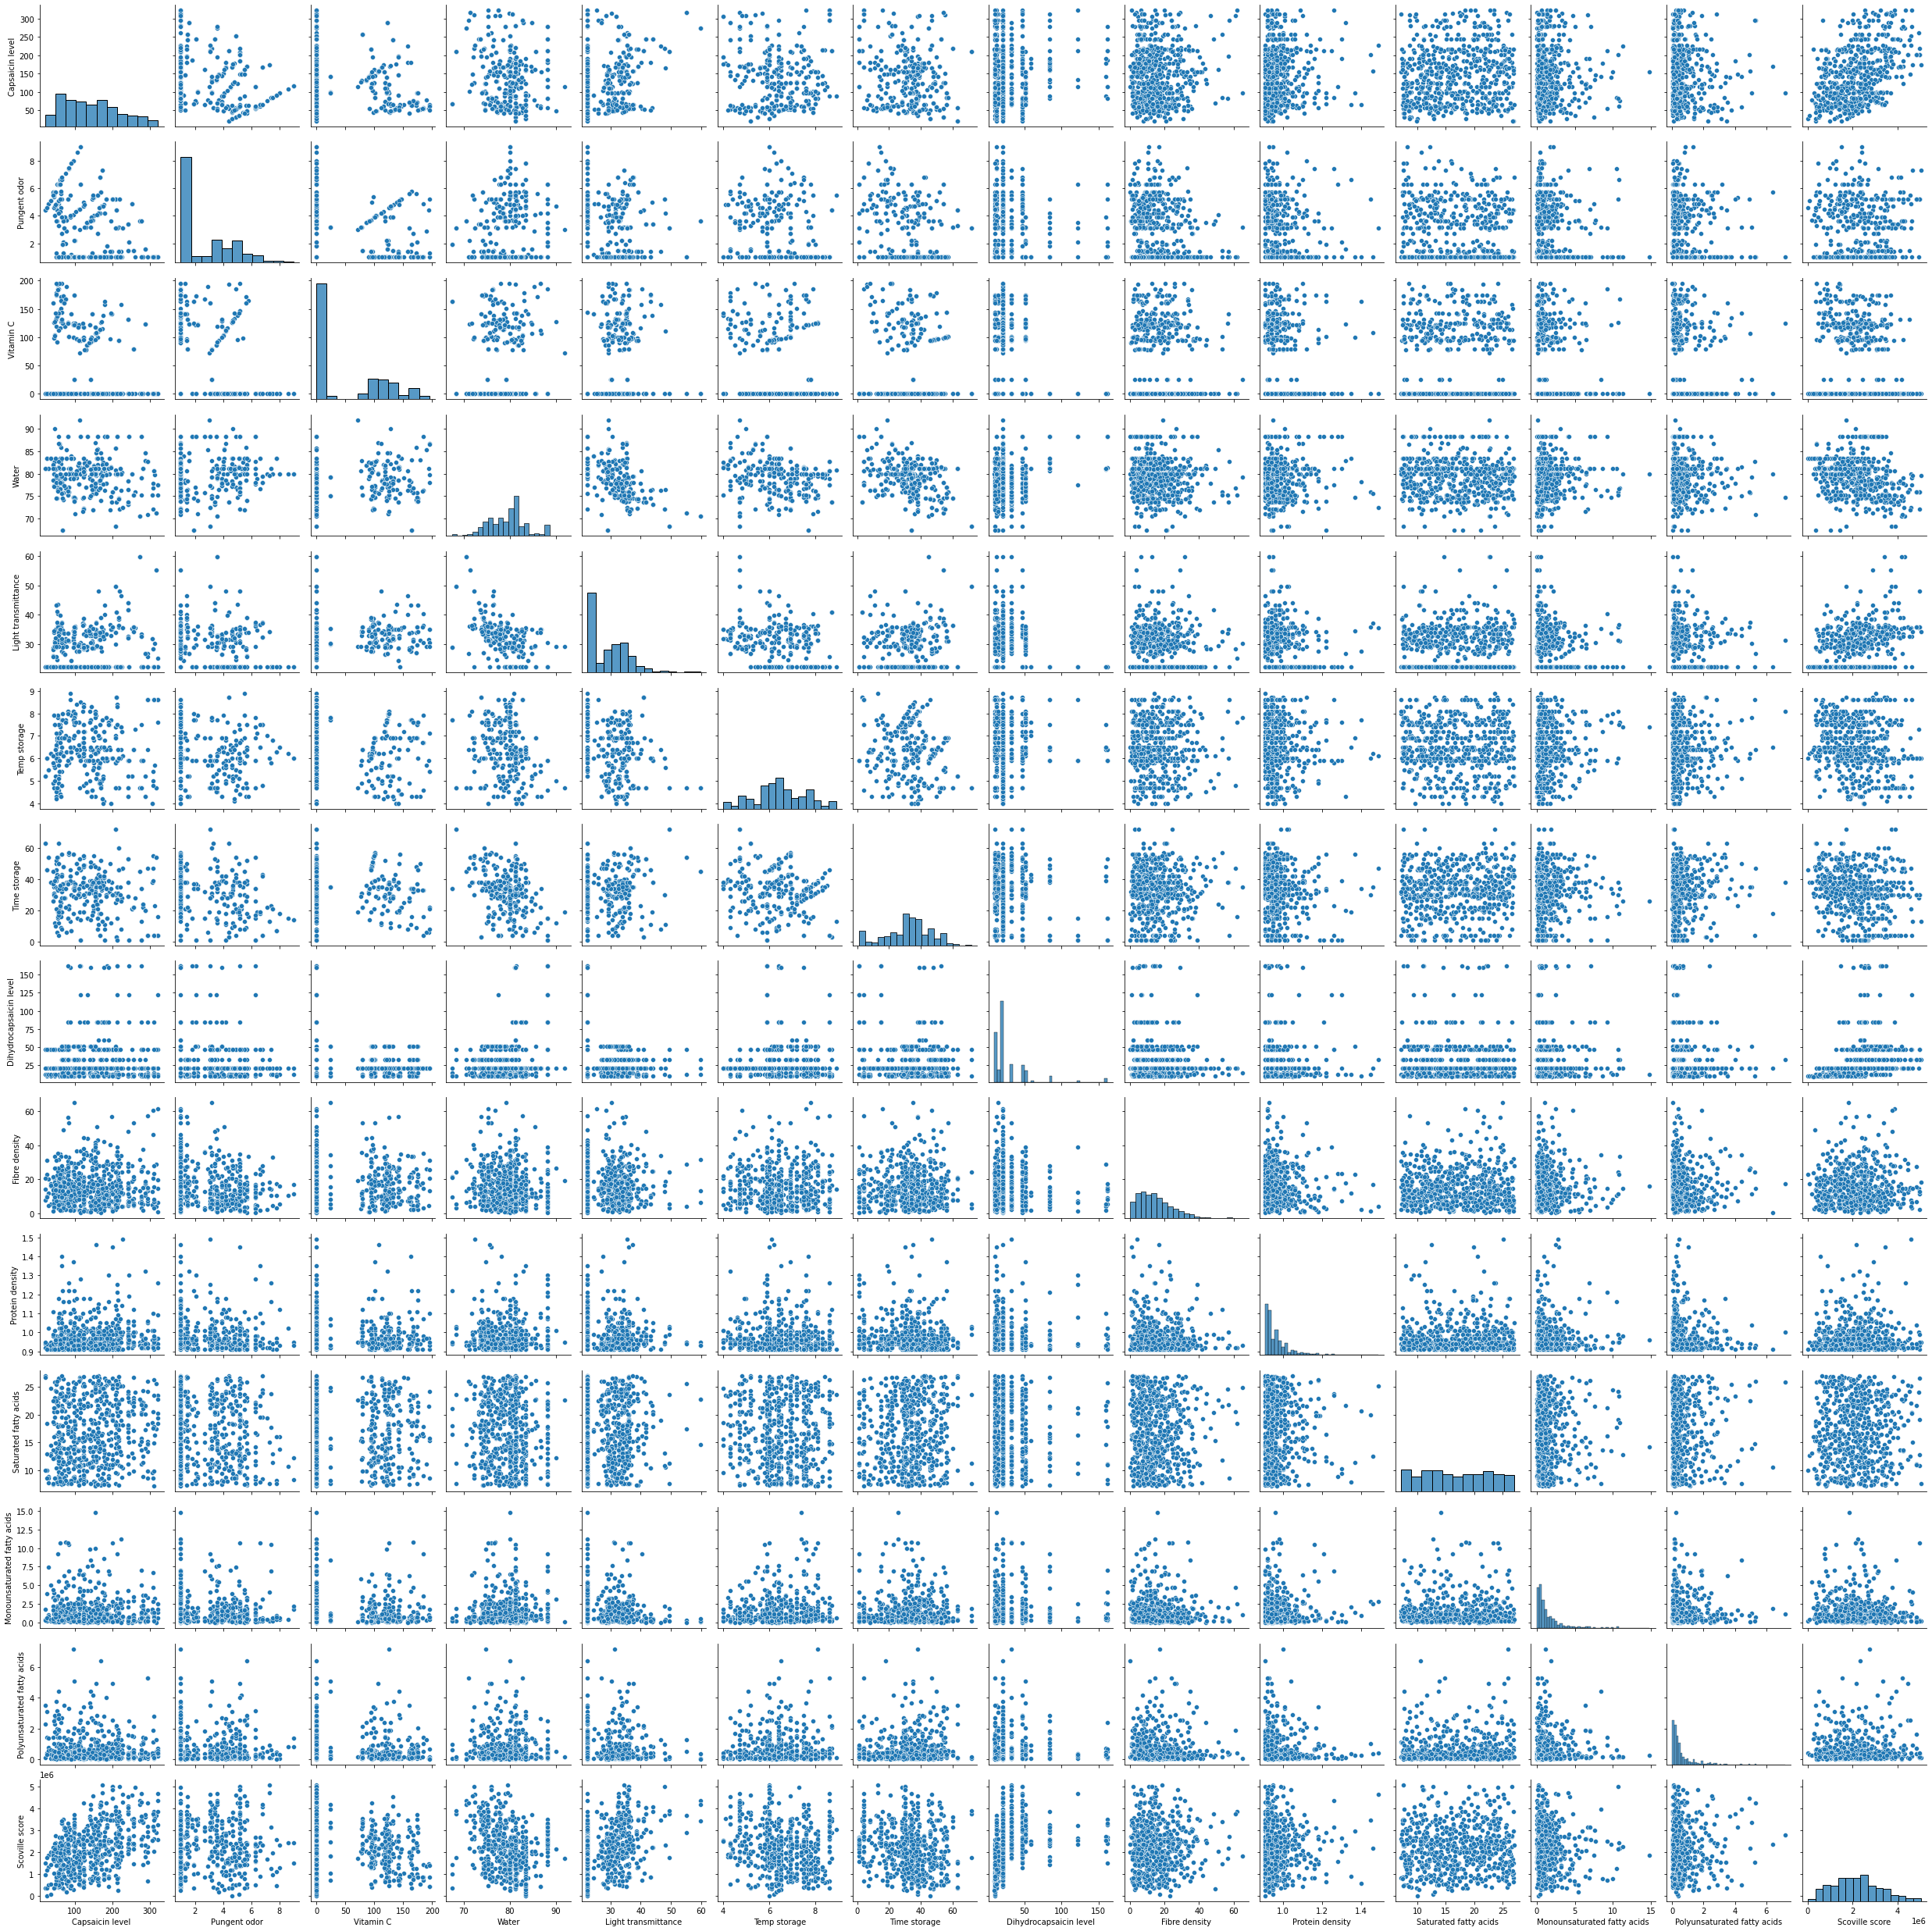

In [6]:
# Pair plot of the data
plt.figure(figsize=(16, 9))
sns.pairplot(data=training_data)
plt.show()

<Figure size 1152x648 with 0 Axes>

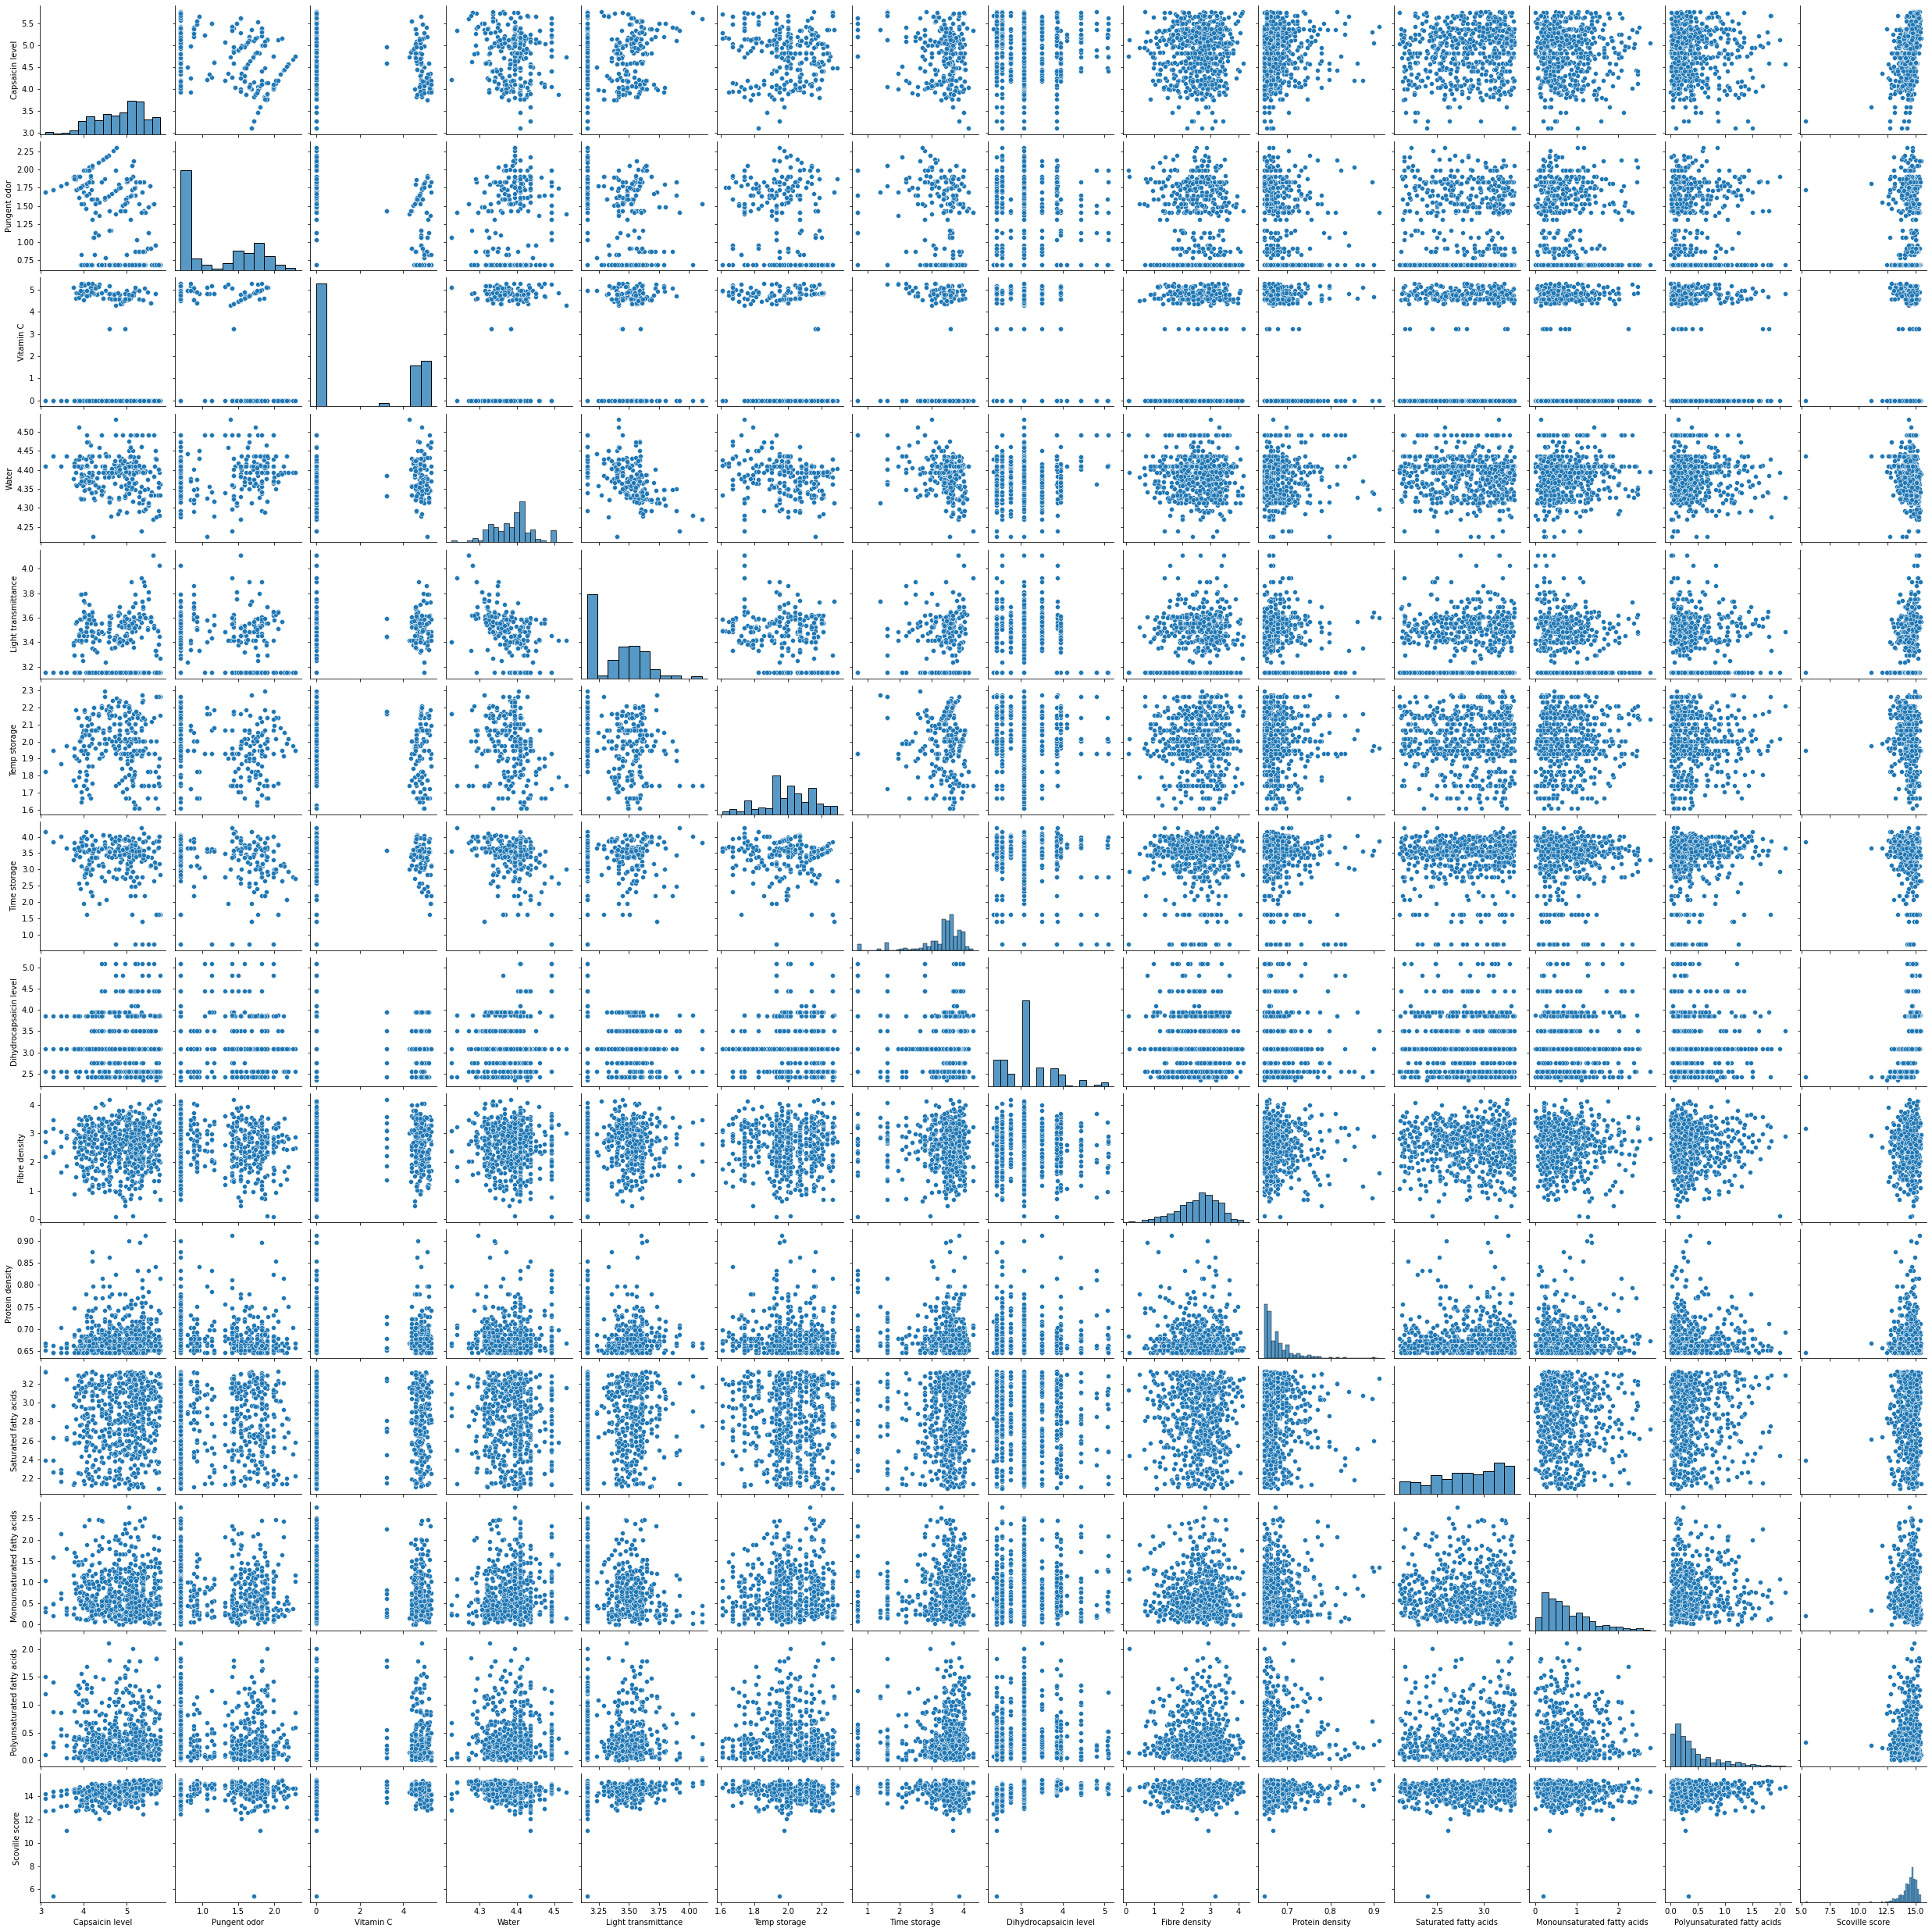

In [7]:
# Pair plot of the data log-transformed
plt.figure(figsize=(16, 9))
sns.pairplot(data=np.log(training_data + 1))
plt.show()

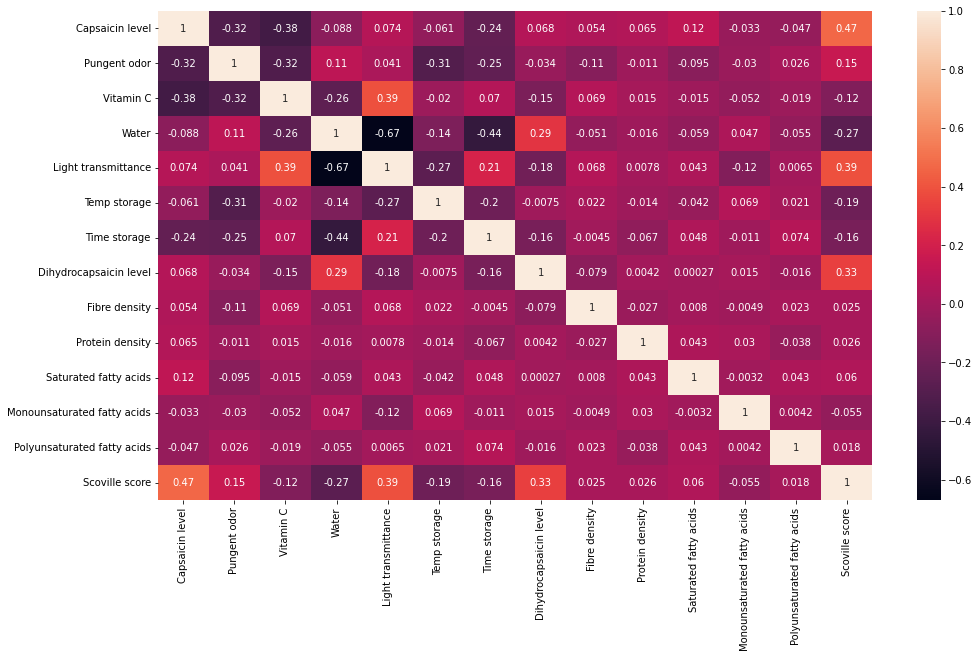

In [8]:
# Correlation matrix
corr_matrix = training_data.corr()
plt.figure(figsize=(16, 9))
sns.heatmap(data=corr_matrix, annot=True)
plt.show()

### Data cleaning

In [9]:
# Remove outliers
cleaned_data = training_data.copy()
cleaned_data = cleaned_data[(np.abs(stats.zscore(cleaned_data)) < 3).all(axis=1)]
cleaned_data.index = range(cleaned_data.shape[0])

In [10]:
# Remove the data point where
idx = int(np.where(cleaned_data['Scoville score'] == np.min(cleaned_data['Scoville score']))[0])
cleaned_data = cleaned_data.drop(index=idx, axis=1)
cleaned_data.index = range(cleaned_data.shape[0])

### Data exploration after cleaning

<Figure size 1152x648 with 0 Axes>

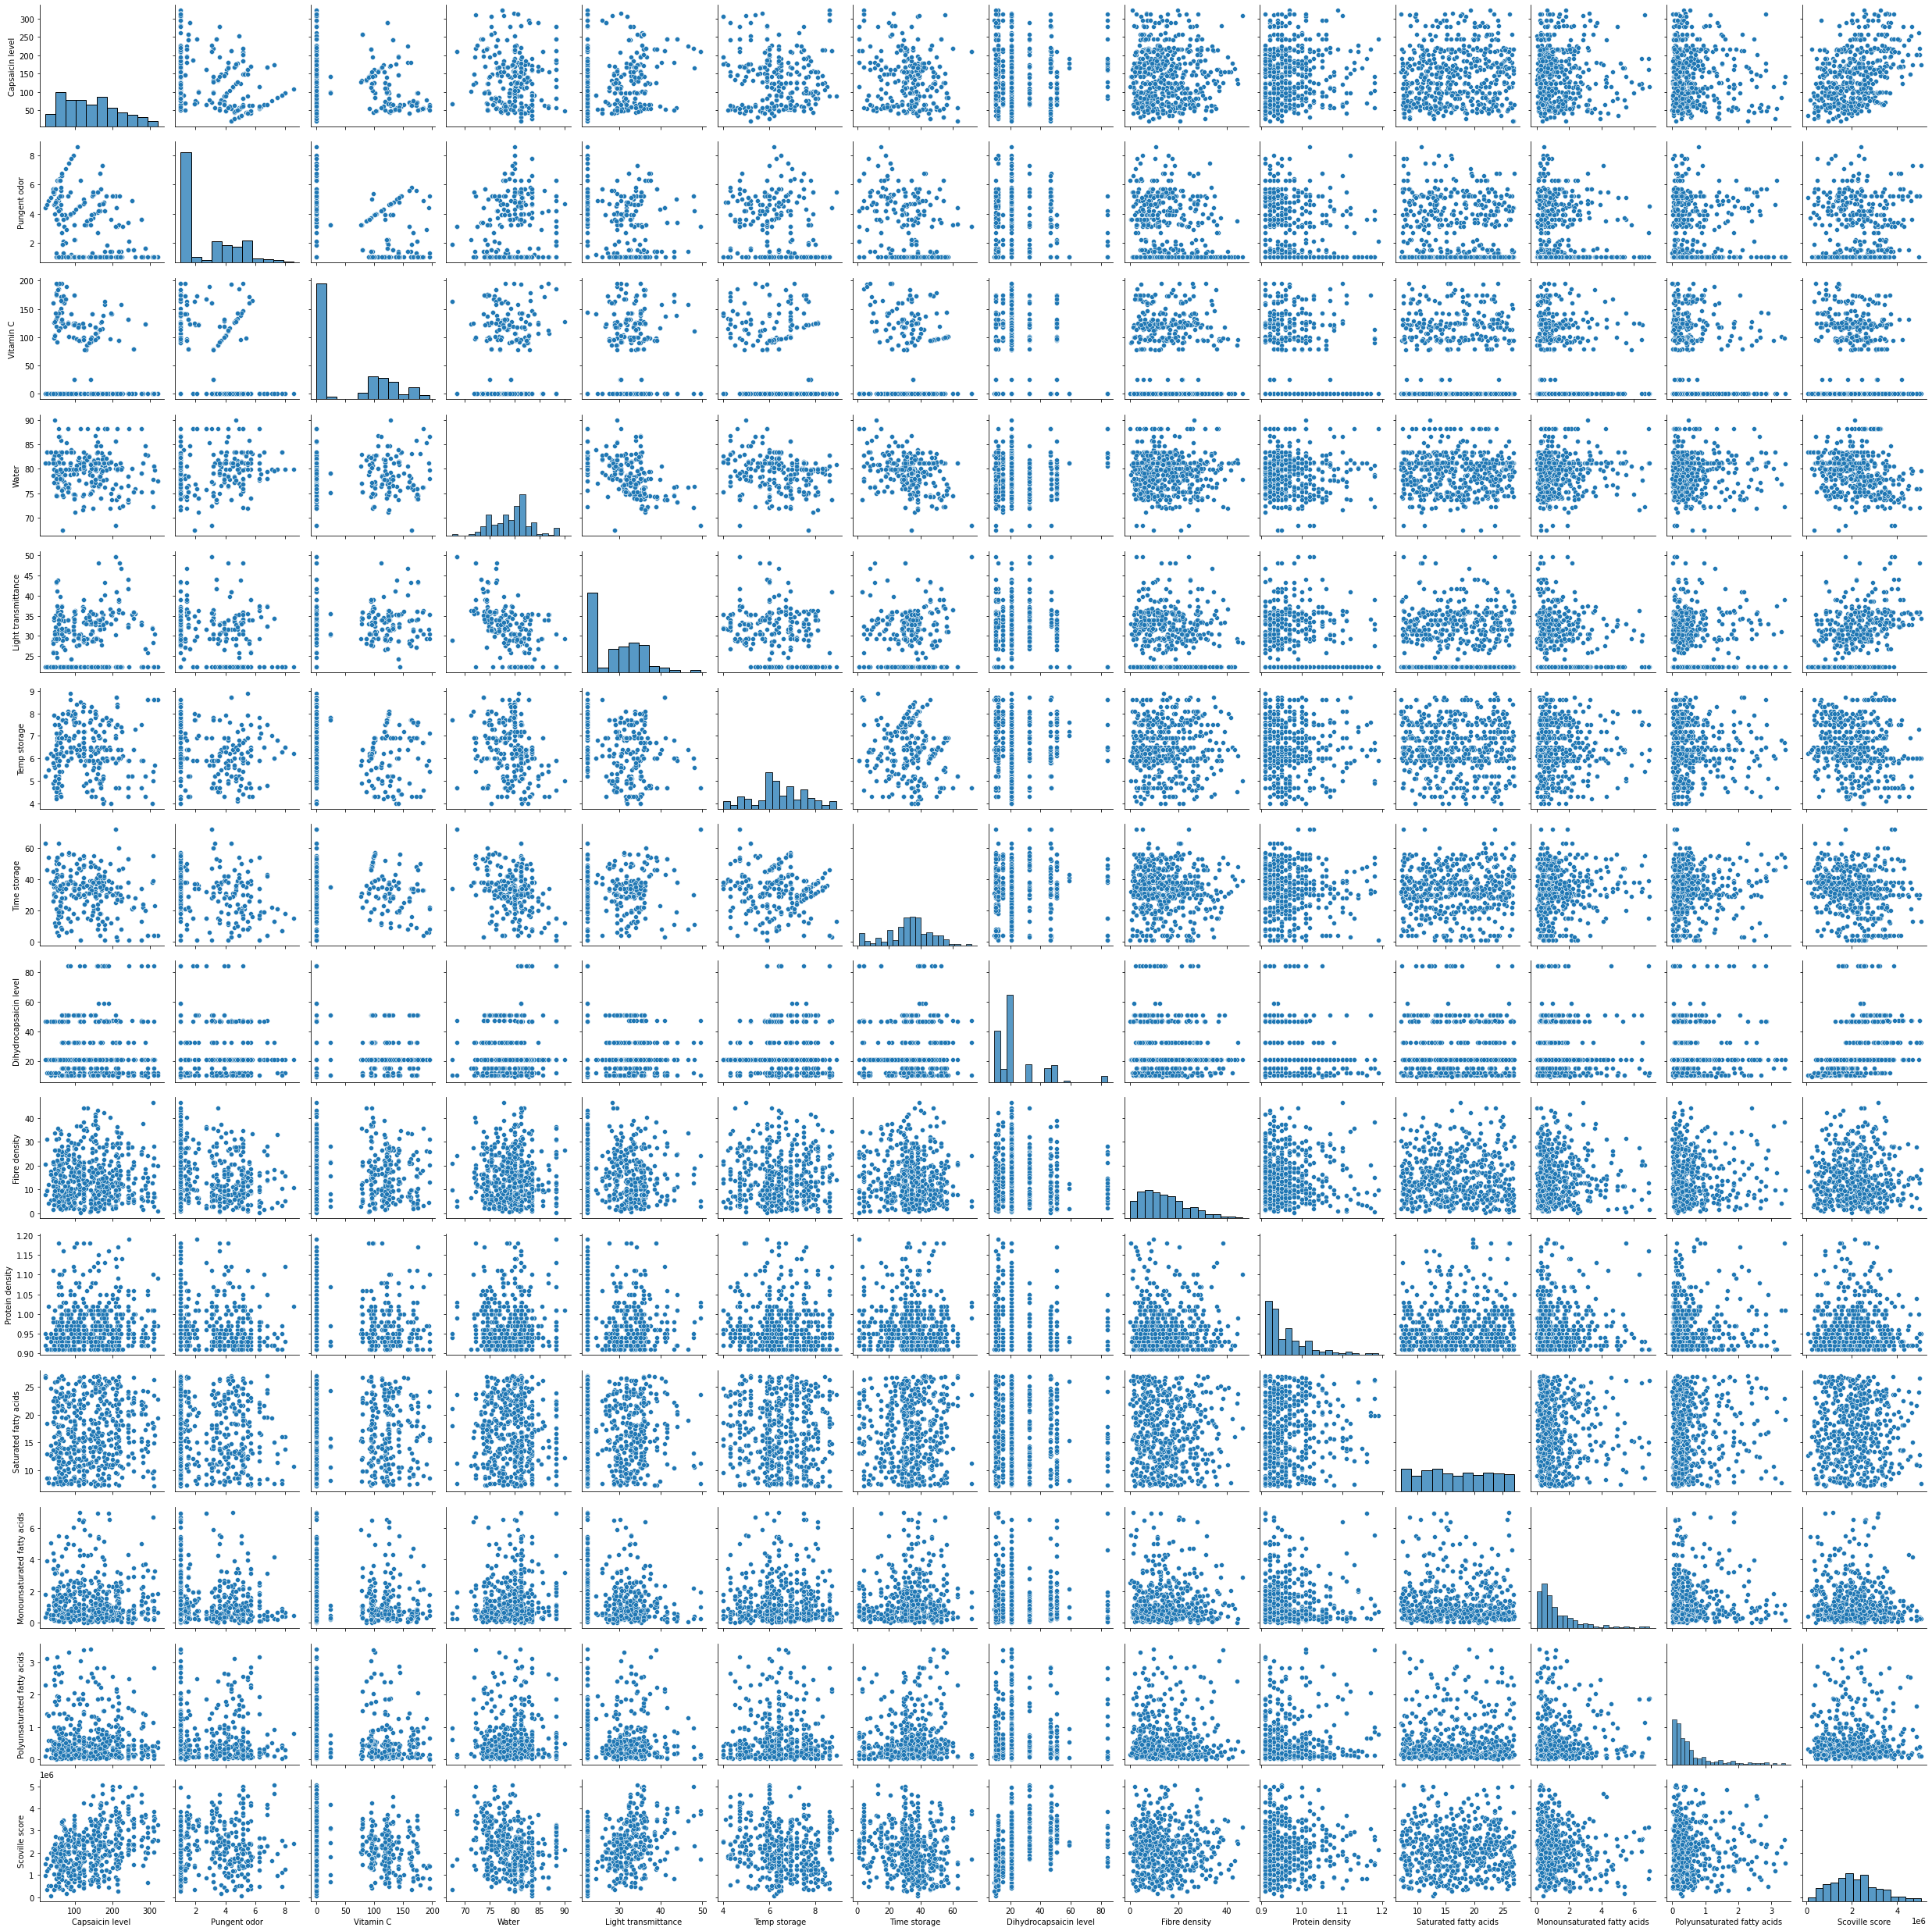

In [11]:
# Pair plot after removing outliers
plt.figure(figsize=(16, 9))
sns.pairplot(data=cleaned_data)
plt.show()

### Data preprocessing

In [12]:
X = cleaned_data.iloc[:, :-1]
y = cleaned_data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3,
                                                    random_state=1)

### Modelling

In [13]:
def eval_metrics(y_true, y_pred, output_str):
    print(5*'-', output_str, 5*'-')
    print(f'{output_str} score (MAE): {mean_absolute_error(y_true, y_pred):.4f}' )
    print(f'{output_str} score (R^2): {r2_score(y_true, y_pred):.4f}')
    print(f'{output_str} score (RMSE): {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}')
    print()

#### Data pipeline with regression model

In [14]:
# Random forest regression model
rfr_pipe = make_pipeline(StandardScaler(),
                         RandomForestRegressor(criterion='absolute_error',
                                               random_state=163,
                                               n_jobs=-1))

In [15]:
# Nested cross-validation for the model

inner_segments = 10
outer_segments = 10

rfr_grid = [{'randomforestregressor__max_depth': [3, 5, 10],
             'randomforestregressor__max_features': ['sqrt', 'log2', None]}]

rfr_gs = GridSearchCV(estimator=rfr_pipe,
                      param_grid=rfr_grid,
                      scoring='neg_mean_absolute_error',
                      cv=inner_segments,
                      n_jobs=-1)

scores_nested_rfr = cross_val_score(rfr_gs, X_train, y_train, 
                                    scoring='neg_mean_absolute_error', 
                                    cv=outer_segments)

print(f'CV accuracy: {np.mean(scores_nested_rfr):.3f} +/- {np.std(scores_nested_rfr):.3f}')

CV accuracy: -343581.368 +/- 45667.862


In [16]:
# Fit the model with the 'best' parameters to the training data
rfr_model = rfr_gs.fit(X_train, y_train)
print(rfr_model.best_params_)

# Use the model to predict on the training and test set
y_train_pred = rfr_model.predict(X_train)
y_test_pred = rfr_model.predict(X_test)

# Evaluate the MAE of the predicted values compared to the 'ground truth'
eval_metrics(y_train, y_train_pred, 'Training')
eval_metrics(y_test, y_test_pred, 'Testing')

{'randomforestregressor__max_depth': 10, 'randomforestregressor__max_features': None}
----- Training -----
Training score (MAE): 136396.6184
Training score (R^2): 0.9713
Training score (RMSE): 177812.7658

----- Testing -----
Testing score (MAE): 336888.7757
Testing score (R^2): 0.8230
Testing score (RMSE): 423628.7003



#### Data pipeline with classification model

##### Binning train target values

Can be performed with ex. pandas.qcut or pandas.cut

```python
n_bins = 10
y_train_binned = pd.cut(y_train, n_bins, labels=False) # or
y_train_binned = pd.qcut(y_train, n_bins, labels=False) 
```

In [17]:
xgb_clf = xgb.XGBClassifier(objective='multi:softprob', random_state=2, 
                            verbosity=0, eval_metric='mae')

In [18]:
def bin_converter(y_binned, bins):
    """
    Converts the predicted class labels (0, 1, 2, etc.) into the relating value
    in the bins.
    """
    for i, bin_value in enumerate(y_binned):
        y_binned[i] = bins[bin_value]

In [19]:
for n_bins in [15, 10, 5]:
    y_train_binned, bins = pd.cut(y_train, n_bins, labels=False, retbins=True)
    inner_segments = 10

    # Parameter grid for the model
    xgb_grid = [{'xgbclassifier__learning_rate': [x/10 for x in range(1, 4)],
                'xgbclassifier__gamma': [10**x for x in range(-4, 3)],
                'xgbclassifier__subsample': [0.5, 0.7],
                'xgbclassifier__max_depth':[1, 3, 5, 7],
                }]

    # Randomized grid search
    xgb_gs = RandomizedSearchCV(estimator=xgb_clf,
                                param_distributions=xgb_grid, 
                                scoring='neg_mean_absolute_error', 
                                cv=inner_segments, n_iter=10,
                                n_jobs=-1)

    scores_nested_xgb = cross_val_score(xgb_gs, X_train, y_train_binned, 
                                        scoring='neg_mean_absolute_error', 
                                        cv=outer_segments)

    xgb_classifier = xgb_gs.fit(X_train, y_train_binned)

    # print(xgb_classifier.best_params_)

    # Need to convert y_train_binned into a numpy
    # array to easier convert the bins into actual values later in the for loop
    y_train_binned = np.array(y_train_binned)

    # Predictions on training and test set
    y_train_pred = xgb_classifier.predict(X_train)
    y_test_pred = xgb_classifier.predict(X_test)

    # We have to bin the ground truth for the test set
    # with the help of the bins created in the training set.
    y_test_binned = np.digitize(y_test, bins=bins, right=True)

    # Convert all the predicted class labels into bin values
    for binned_y in [y_train_pred, y_test_pred, y_test_binned, y_train_binned]:
        binned_y = bin_converter(binned_y, bins)

    # MAE on the training and test set
    eval_metrics(y_train_binned, y_train_pred, f'Training, num bins: {n_bins}')
    eval_metrics(y_test_binned, y_test_pred, f'Testing,  num bins: {n_bins}')

c:\Users\aarlm\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\aarlm\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\aarlm\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\aarlm\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\aarlm\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.p

----- Training, num bins: 15 -----
Training, num bins: 15 score (MAE): 0.0000
Training, num bins: 15 score (R^2): 1.0000
Training, num bins: 15 score (RMSE): 0.0000

----- Testing,  num bins: 15 -----
Testing,  num bins: 15 score (MAE): 585783.4916
Testing,  num bins: 15 score (R^2): 0.4402
Testing,  num bins: 15 score (RMSE): 754713.3881



c:\Users\aarlm\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\aarlm\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\aarlm\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\aarlm\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\aarlm\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.p

----- Training, num bins: 10 -----
Training, num bins: 10 score (MAE): 0.0000
Training, num bins: 10 score (R^2): 1.0000
Training, num bins: 10 score (RMSE): 0.0000

----- Testing,  num bins: 10 -----
Testing,  num bins: 10 score (MAE): 623025.2849
Testing,  num bins: 10 score (R^2): 0.3922
Testing,  num bins: 10 score (RMSE): 796352.1367

----- Training, num bins: 5 -----
Training, num bins: 5 score (MAE): 0.0000
Training, num bins: 5 score (R^2): 1.0000
Training, num bins: 5 score (RMSE): 0.0000

----- Testing,  num bins: 5 -----
Testing,  num bins: 5 score (MAE): 1001745.3464
Testing,  num bins: 5 score (R^2): -0.2489
Testing,  num bins: 5 score (RMSE): 1172500.2944



The classification model's performance worsens as the number of bins decrease.

#### Other models used for Kaggle submission

#### Regression model #2

In [20]:
X_log = np.log(X + 1) # Log-transform on the features
y_sqrt = np.sqrt(y) # Square-root transform on the target

X_train_log, X_test_log, y_train, y_test = train_test_split(X_log, y_sqrt, test_size=0.3,
                                                            random_state=12)

In [21]:
xgbreg_pipe = make_pipeline(xgb.XGBRegressor(eval_metric='mae', random_state=2))

In [22]:
inner_segments = 12
outer_segments = 12

# Parameter grid for the model
xgb_grid = [{'xgbregressor__learning_rate':loguniform(0.01, 0.4).rvs(20, random_state=1),
             'xgbregressor__gamma': loguniform(0.01, 10).rvs(20, random_state=1),
             'xgbregressor__subsample': np.linspace(0.1, 1, 10),
             'xgbregressor__max_depth': [1, 3, 5, 7],
             'xgbregressor__alpha': loguniform(0.01, 0.3).rvs(20, random_state=1),
             'xgbregressor__lambda': loguniform(0.01, 0.3).rvs(20, random_state=2)}]

# Randomized grid search
xgb_gs = RandomizedSearchCV(xgbreg_pipe, xgb_grid, 
                            scoring='neg_mean_absolute_error', 
                            cv=inner_segments, n_iter=30, n_jobs=-1)

scores_xgb = cross_val_score(xgb_gs, X_train_log, y_train, 
                             scoring='neg_mean_absolute_error',
                             cv=outer_segments, n_jobs=-1)

# print(f'CV MAE: {np.mean(scores_xgb):.3f} +/- {np.std(scores_xgb):.3f}')


In [23]:
# Fit the model on the training data
xgb_regressor = xgb_gs.fit(X_train_log, y_train)

# Get the parameters from the 'best' model
best_params = xgb_regressor.best_params_
print(best_params)

# Make predictions on the training and test set
y_train_pred = xgb_regressor.predict(X_train_log)
y_test_pred = xgb_regressor.predict(X_test_log)

# Evaluate the MAE of the predicted values compared to the 'ground truth'.
# We have to square our predictions and ground truth as we square-root transformed the target
eval_metrics(y_train**2, y_train_pred**2, f'Training')
eval_metrics(y_test**2, y_test_pred**2, f'Testing')

{'xgbregressor__subsample': 0.9, 'xgbregressor__max_depth': 3, 'xgbregressor__learning_rate': 0.12524567764709546, 'xgbregressor__lambda': 0.14455570593664688, 'xgbregressor__gamma': 0.03620600725744739, 'xgbregressor__alpha': 0.01961642761814289}
----- Training -----
Training score (MAE): 123670.6873
Training score (R^2): 0.9747
Training score (RMSE): 163242.6922

----- Testing -----
Testing score (MAE): 262877.5421
Testing score (R^2): 0.8811
Testing score (RMSE): 363748.0882



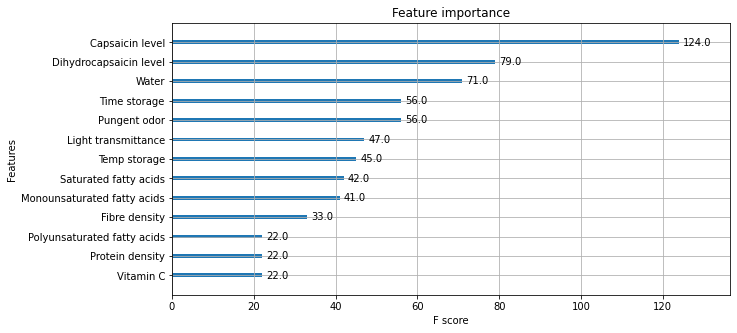

In [24]:
# Create a model based on the best parameters
xgb_model = xgb.XGBRegressor(subsample=best_params['xgbregressor__subsample'], 
                             max_depth=best_params['xgbregressor__max_depth'],
                             learning_rate=best_params['xgbregressor__learning_rate'],
                             reg_lambda=best_params['xgbregressor__lambda'],
                             gamma=best_params['xgbregressor__gamma'],
                             alpha=best_params['xgbregressor__alpha'],
                             random_state=2)
xgb_model = xgb_model.fit(X_train_log, y_train)

# Plot the feature importance to evaluate whether or not some features are redundant
fig, ax = plt.subplots(figsize=(10, 5))
xgb.plot_importance(xgb_model, ax=ax)
plt.show()

In [25]:
# Get the y_ticklabels in ascending order, as shown in the plot above
y_ticklabels = ax.get_yticklabels()
features_sorted = []

for yticklabel in y_ticklabels:
    features_sorted.append(yticklabel.get_text())

# We then select which of the features we're going to remove, going bottom up 
removed_features = features_sorted[:6] 

In [26]:
# We then make a copy of our log-transformed data and remove the unwanted features
X_log_refined = X_log.copy()
X_log_refined = X_log.drop(removed_features, axis=1)

X_train_log, X_test_log, y_train, y_test = train_test_split(X_log_refined, y_sqrt, test_size=0.3,
                                                            random_state=12)

In [27]:
xgb_model = xgb.XGBRegressor(subsample=best_params['xgbregressor__subsample'], 
                             max_depth=best_params['xgbregressor__max_depth'],
                             learning_rate=best_params['xgbregressor__learning_rate'],
                             reg_lambda=best_params['xgbregressor__lambda'],
                             gamma=best_params['xgbregressor__gamma'],
                             alpha=best_params['xgbregressor__alpha'])

# By the help of the model with the 'best' parameters we now fit our new data onto it
# and make predictions
xgb_model = xgb_model.fit(X_train_log, y_train)
y_train_pred = xgb_model.predict(X_train_log)
y_test_pred = xgb_model.predict(X_test_log)

# Then we evaluate the MAE the same as before.
eval_metrics(y_train**2, y_train_pred**2, f'Training')
eval_metrics(y_test**2, y_test_pred**2, f'Testing')

----- Training -----
Training score (MAE): 133691.9367
Training score (R^2): 0.9695
Training score (RMSE): 178959.9837

----- Testing -----
Testing score (MAE): 240941.8021
Testing score (R^2): 0.8951
Testing score (RMSE): 341637.1658



### Final Evaluation

### Kaggle submission

In [30]:
test = pd.read_csv(r'data\test.csv')
test = test.drop('Unnamed: 0', axis=1)

In [31]:
# We log-transform the test_data as we did the training data
test_log = np.log(test + 1)

# We remove the features which where not used to train our final model 
test_log = test_log.drop(removed_features, axis=1)

# We make predictions and square them
predictions = xgb_model.predict(test_log)**2

my_submission = pd.DataFrame({'Id': list(range(len(predictions))),
                              'Scoville score': predictions})
my_submission.to_csv(r'submissions/XGBRegressor18_log_sqrt_removedFewFeatures.csv', index=False)